In [2]:
import os
import sys

#  Set the working directory to the folder containing the top-level ultralytics package
os.chdir("/workspace")  # change to your workspace root where ultralytics folder exists
print("Current working directory:", os.getcwd())


Current working directory: /workspace


In [3]:
!git clone https://github.com/ultralytics/ultralytics.git
%cd ultralytics


Cloning into 'ultralytics'...
remote: Enumerating objects: 67800, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 67800 (delta 61), reused 30 (delta 21), pack-reused 67677 (from 2)
Receiving objects: 100% (67800/67800), 36.01 MiB | 8.35 MiB/s, done.
Resolving deltas: 100% (50671/50671), done.
Updating files: 100% (778/778), done.
/workspace/ultralytics


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import os
import sys

#  Set the working directory to the folder containing the top-level ultralytics package
print("Current working directory:", os.getcwd())


Current working directory: /workspace


In [3]:
#  Add the top-level ultralytics folder to Python path
os.chdir("/workspace/ultralytics")
print("Current working directory:", os.getcwd())

Current working directory: /workspace/ultralytics


In [33]:
from ultralytics import YOLO

# -------------------------------
# Load YAML (with original SPPF)
# -------------------------------
model = YOLO('yolov8.yaml')
print("Original model loaded ")


WARNING ⚠️ no model scale passed. Assuming scale='n'.
Original model loaded 


In [5]:
import ultralytics
print(ultralytics.__file__)


/workspace/ultralytics/ultralytics/__init__.py


In [34]:
from ultralytics.models.yolo.model import YOLO

# Load your YOLOv8 model (with CBAM if added)
model = YOLO("ultralytics/cfg/models/v8/yolov8.yaml")

# Print the full architecture
print(model.model)   # model.model contains the actual PyTorch nn.Module


WARNING ⚠️ no model scale passed. Assuming scale='n'.
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stat

In [35]:
print("Current working directory:", os.getcwd())


Current working directory: /workspace/ultralytics


In [27]:
import torch
from ultralytics import YOLO

# --- Load model ---
model = YOLO("yolov8.yaml")  # your custom model
model.eval()  # evaluation mode

# --- Create dummy input ---
dummy_img = torch.randn(1, 3, 640, 640)  # batch_size=1, 3 channels, 640x640

# --- Forward pass through the model ---
with torch.no_grad():
    preds = model.model(dummy_img)  # list of outputs from YOLO layers

# --- Pick one output and compute a dummy EIoU loss ---
from ultralytics.utils.loss import BboxLoss
from ultralytics.utils.metrics import bbox_iou

# fake target boxes (x1,y1,x2,y2)
target_boxes = torch.tensor([[100, 100, 200, 200]], dtype=torch.float32)
pred_boxes = torch.tensor([[110, 110, 210, 210]], dtype=torch.float32)

bbox_loss_fn = BboxLoss()
# Mask & dummy target scores
fg_mask = torch.tensor([True])
target_scores = torch.tensor([[1.0]])
target_scores_sum = torch.tensor(1.0)

loss_iou, loss_dfl = bbox_loss_fn(
    pred_dist=torch.zeros(1, 16, 4),      # dummy DFL input
    pred_bboxes=pred_boxes,
    anchor_points=torch.zeros(1, 2),      # dummy anchors
    target_bboxes=target_boxes,
    target_scores=target_scores,
    target_scores_sum=target_scores_sum,
    fg_mask=fg_mask
)

print(f"[Sanity Check] loss_iou = {loss_iou.item()}, loss_dfl = {loss_dfl.item()}")


WARNING ⚠️ no model scale passed. Assuming scale='n'.
[Sanity Check] loss_iou = 0.3275921940803528, loss_dfl = 2.7725887298583984


In [ ]:
from ultralytics import YOLO
import time
import torch

# === Device setup ===
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# === Load default YOLOv8 architecture ===
model = YOLO("yolov8.yaml").to(device)  # Use default YAML, not custom CBAM YAML

# === Set box loss to EIoU only ===
model.box_loss_type = "eiou"  # Enable EIoU
# Classification and objectness remain default BCE
model.cls_loss_type = "bce"  # placeholder (doesn't impact)
model.obj_loss_type = "bce"  # placeholder (doesn't impact)

# === Enable EMA ===
model.ema = True

# === Training parameters ===
dataset_yaml = "/workspace/datasets/KITTI/kitti.yml"  # Custom KITTI dataset YAML
run_name = "yolov8n_eiou_base_hypers_pat20"  # Run name for saving logs and weights
epochs = 2
imgsz = 1280
batch_size = 32
workers = 2
cache_images = "disk"
amp = True
save_interval = 50
patience = 20

# === EMA status ===
print("\n=== EMA STATUS ===")
print(f"EMA enabled: {model.ema}")

# === Detect layer info ===
print("\n=== DETECT LAYER INFO ===")
detect_layer = model.model.model[-1]
print(f"  Classes (nc): {detect_layer.nc}")
try:
    print(f"  Strides: {detect_layer.stride}")
    print(f"  Number of detection heads: {len(detect_layer.stride)}")
except Exception as e:
    print(f"  Could not read strides/heads: {e}")

# === Model summary ===
print("\n=== MODEL SUMMARY ===")
print(model.model)

# === Loss type verification ===
print("\n=== LOSS TYPE VERIFICATION ===")
print(f"Box loss type: {model.box_loss_type}")
print(f"Class loss type: {model.cls_loss_type}")
print(f"Object loss type: {model.obj_loss_type}")

# === Start full training ===
print("\n=== STARTING FULL TRAINING ===")
start_time = time.time()

results = model.train(
    data=dataset_yaml,
    epochs=epochs,
    imgsz=imgsz,
    batch=batch_size,
    workers=workers,
    device=device,
    cache=cache_images,
    name=run_name,
    save=True,
    amp=amp,
    patience=patience,
    save_period=save_interval,
    pretrained="yolov8n.pt",  # Use COCO pretrained weights
    optimizer="AdamW",
    lr0=0.001,
    weight_decay=1e-4,
    cos_lr=True,
    lrf=0.01,
    augment=True
)

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/3600:.2f} hours")



=== EMA STATUS ===
EMA enabled: True

=== DETECT LAYER INFO ===
  Classes (nc): 7
  Strides: tensor([ 8., 16., 32.], device='cuda:0')
  Number of detection heads: 3

=== MODEL SUMMARY ===
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32,

In [ ]:
from ultralytics import YOLO
import time
import torch

# === Device setup ===
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# === Load default YOLOv8 architecture ===
model = YOLO("yolov8.yaml").to(device)  # Use default YAML, not custom CBAM YAML

# === Set box loss to EIoU only ===
model.box_loss_type = "eiou"  # Enable EIoU
# Classification and objectness remain default BCE
model.cls_loss_type = "bce"  # placeholder (doesn't impact)
model.obj_loss_type = "bce"  # placeholder (doesn't impact)

# === Enable EMA ===
model.ema = True

# === Training parameters ===
dataset_yaml = "/workspace/datasets/KITTI/kitti.yml"  # Custom KITTI dataset YAML
run_name = "yolov8n_eiou_base_hypers_pat20"  # Run name for saving logs and weights
epochs = 250
imgsz = 1280
batch_size = 32
workers = 2
cache_images = "disk"
amp = True
save_interval = 50
patience = 20

# === EMA status ===
print("\n=== EMA STATUS ===")
print(f"EMA enabled: {model.ema}")

# === Detect layer info ===
print("\n=== DETECT LAYER INFO ===")
detect_layer = model.model.model[-1]
print(f"  Classes (nc): {detect_layer.nc}")
try:
    print(f"  Strides: {detect_layer.stride}")
    print(f"  Number of detection heads: {len(detect_layer.stride)}")
except Exception as e:
    print(f"  Could not read strides/heads: {e}")

# === Model summary ===
print("\n=== MODEL SUMMARY ===")
print(model.model)

# === Loss type verification ===
print("\n=== LOSS TYPE VERIFICATION ===")
print(f"Box loss type: {model.box_loss_type}")
print(f"Class loss type: {model.cls_loss_type}")
print(f"Object loss type: {model.obj_loss_type}")

# === Start full training ===
print("\n=== STARTING FULL TRAINING ===")
start_time = time.time()

results = model.train(
    data=dataset_yaml,
    epochs=epochs,
    imgsz=imgsz,
    batch=batch_size,
    workers=workers,
    device=device,
    cache=cache_images,
    name=run_name,
    save=True,
    amp=amp,
    patience=patience,
    save_period=save_interval,
    pretrained="yolov8n.pt",  # Use COCO pretrained weights
    optimizer="AdamW",
    lr0=0.001,
    weight_decay=1e-4,
    cos_lr=True,
    lrf=0.01,
    augment=True
)

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/3600:.2f} hours")



=== EMA STATUS ===
EMA enabled: True

=== DETECT LAYER INFO ===
  Classes (nc): 7
  Strides: tensor([ 8., 16., 32.], device='cuda:0')
  Number of detection heads: 3

=== MODEL SUMMARY ===
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     91/250      17.9G      0.685     0.4153      0.902        372       1280: 100% ━━━━━━━━━━━━ 187/187 1.9it/s 1:400.5sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 6.0it/s 4.0s0.2s
                   all       1497       7772      0.907      0.858      0.907       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     92/250      17.9G     0.6803     0.4093     0.8998        503       1280: 100% ━━━━━━━━━━━━ 187/187 1.9it/s 1:410.5sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 6.0it/s 4.0s0.2s
                   all       1497       7772       0.91      0.856      0.914       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     93/250      17.9G     0.6753     0.4055     0.8985        356       1280: 100% ━━━━━━━━━━━━ 187/187 1.9it/s 1:410.4sss
                 Class     Ima

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    158/250      17.9G     0.5794     0.3474      0.865        320       1280: 100% ━━━━━━━━━━━━ 187/187 1.9it/s 1:400.5sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 5.9it/s 4.0s0.2s
                   all       1497       7772      0.908      0.885       0.93       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    159/250      17.9G     0.5781     0.3453      0.865        355       1280: 100% ━━━━━━━━━━━━ 187/187 1.9it/s 1:400.5sss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 6.0it/s 4.0s0.2s
                   all       1497       7772      0.902      0.895      0.931      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    160/250      17.9G     0.5761     0.3446     0.8647        344       1280: 100% ━━━━━━━━━━━━ 187/187 1.9it/s 1:410.5sss
                 Class     Ima

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
import sys
from pathlib import Path
import torch
import time
from ultralytics import YOLO  # Use YOLOv8's interface

weights = "runs/detect/yolov8n_eiou_base_hypers_pat20/weights/best.pt"
dataset_yaml = "/workspace/datasets/KITTI/kitti.yml"
results_dir = "/workspace/yolov8n_eiou_base_hypers_pat20_val"

# ------------------- Device -------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ------------------- Load model -------------------
model = YOLO(weights)  # Load the model using YOLOv8
params = sum(p.numel() for p in model.model.parameters())
params_mb = params * 4 / (1024**2)  # float32 -> 4 bytes
model_size_mb = Path(weights).stat().st_size / 1024**2  # file size in MB

print(f"Model size (file): {model_size_mb:.2f} MB")
print(f"Model parameters: {params_mb:.2f} MB")

# ------------------- FPS Measurement -------------------
dummy_input = torch.randn(1, 3, 1280, 1280).to(device) / 255.0  # Normalize the dummy input
# Warm-up
for _ in range(5):
    _ = model(dummy_input)  # Use the model directly for inference

n_runs = 50
start_time = time.time()
for _ in range(n_runs):
    _ = model(dummy_input)  # Use the model directly for inference
end_time = time.time()

fps = n_runs / (end_time - start_time)
print(f"Inference FPS (1280x1280): {fps:.2f}")

# ------------------- Run Validation -------------------
print("\nRunning YOLOv8 validation...")
start_val_time = time.time()
model.val(
    data=dataset_yaml,  # Validation dataset
    imgsz=1280,          # Image size
    batch=64,            # Corrected batch size argument
    device=device,       # Device
    project=results_dir, # Results directory
    name="eval_metrics", # Name for saved results
    save_json=True,      # Save results as JSON
    exist_ok=True,       # Overwrite if results directory exists
    verbose=True         # Show verbose output
)
end_val_time = time.time()

val_time = end_val_time - start_val_time
print(f"Validation time: {val_time:.2f} seconds")
print(f"Validation results saved to {results_dir}")


Model size (file): 5.99 MB
Model parameters: 11.49 MB

0: 1280x1280 (no detections), 5.3ms
Speed: 0.0ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 (no detections), 5.7ms
Speed: 0.0ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 (no detections), 5.1ms
Speed: 0.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 1280x1280 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)



In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# CONFIGURATION
# -----------------------------
class_names = ["Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram"]
num_classes = len(class_names)

# -----------------------------
# CONFUSION MATRIX (predicted rows x true cols)
# -----------------------------
conf_matrix = np.array([
    [5529, 9, 1, 0, 0, 0, 0, 407],
    [3, 543, 2, 0, 0, 0, 0, 45],
    [0, 0, 189, 0, 0, 0, 0, 11],
    [0, 0, 0, 783, 0, 4, 0, 156],
    [0, 0, 0, 0, 22, 0, 0, 13],
    [0, 0, 0, 4, 0, 277, 0, 46],
    [0, 1, 0, 0, 0, 0, 97, 14],
    [148, 10, 6, 109, 8, 25, 2, 0]
])

# -----------------------------
# PER-CLASS LOG
# -----------------------------
per_class_precision = [0.961, 0.953, 0.967, 0.941, 0.793, 0.918, 0.907]  
per_class_recall = [0.959, 0.954, 0.955, 0.794, 0.638, 0.881, 0.949]  
per_class_map50 = [0.985, 0.98, 0.98, 0.904, 0.759, 0.939, 0.958]
per_class_map5095 = [0.88, 0.863, 0.891, 0.578, 0.544, 0.736, 0.844]

# -----------------------------
# COMPUTE METRICS
# -----------------------------
metrics_data = []
total_samples = np.sum(conf_matrix)

for i, cname in enumerate(class_names):
    TP = conf_matrix[i, i]
    FP = np.sum(conf_matrix[i, :]) - TP
    FN = np.sum(conf_matrix[:, i]) - TP
    TN = total_samples - (TP + FP + FN)

    #Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    #Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    Precision = per_class_precision[i] 
    Recall = per_class_recall[i]        
    F1 = 2 * Precision * Recall / (Precision + Recall) if (Precision + Recall) > 0 else 0
    Accuracy = (TP + TN) / total_samples if total_samples > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    metrics_data.append({
        "Class": cname,
        "TP": int(TP),
        "FP": int(FP),
        "FN": int(FN),
        "TN": int(TN),
        "Precision": round(per_class_precision[i], 4),
        "Recall": round(per_class_recall[i], 4),
        "F1 Score": round(F1, 4),
        "Accuracy": round(Accuracy, 4),
        "FPR": round(FPR, 4),
        "FNR": round(FNR, 4),
        "mAP@0.5": per_class_map50[i],
        "mAP@0.5:0.95": per_class_map5095[i]
    })

# -----------------------------
# OVERALL ROW
# -----------------------------
TP_total = sum(row["TP"] for row in metrics_data)
FP_total = sum(row["FP"] for row in metrics_data)
FN_total = sum(row["FN"] for row in metrics_data)
TN_total = sum(row["TN"] for row in metrics_data)

overall = {
    "Class": "Overall",
    "TP": TP_total,
    "FP": FP_total,
    "FN": FN_total,
    "TN": TN_total,
    "Precision": np.mean([row["Precision"] for row in metrics_data]),
    "Recall": np.mean([row["Recall"] for row in metrics_data]),
    "F1 Score": np.mean([row["F1 Score"] for row in metrics_data]),
    "Accuracy": np.mean([row["Accuracy"] for row in metrics_data]),
    "FPR": np.mean([row["FPR"] for row in metrics_data]),
    "FNR": np.mean([row["FNR"] for row in metrics_data]),
    "mAP@0.5": np.mean([row["mAP@0.5"] for row in metrics_data]),
    "mAP@0.5:0.95": np.mean([row["mAP@0.5:0.95"] for row in metrics_data])
}

metrics_data.append(overall)

# -----------------------------
# SAVE TO CSV
# -----------------------------
df_metrics = pd.DataFrame(metrics_data)
df_metrics.to_csv("yolov8l_eiou_hypers_pat20_metrics.csv", index=False)
print(df_metrics)


            Class    TP   FP   FN     TN  Precision    Recall  F1 Score  \
0             Car  5529  417  151   2367      0.961  0.959000  0.960000   
1             Van   543   50   20   7851      0.953  0.954000  0.953500   
2           Truck   189   11    9   8255      0.967  0.955000  0.961000   
3      Pedestrian   783  160  113   7408      0.941  0.794000  0.861300   
4  Person_sitting    22   13    8   8421      0.793  0.638000  0.707100   
5         Cyclist   277   50   29   8108      0.918  0.881000  0.899100   
6            Tram    97   15    2   8350      0.907  0.949000  0.927500   
7         Overall  7440  716  332  50760      0.920  0.875714  0.895643   

   Accuracy       FPR       FNR   mAP@0.5  mAP@0.5:0.95  
0    0.9329  0.149800  0.026600  0.985000      0.880000  
1    0.9917  0.006300  0.035500  0.980000      0.863000  
2    0.9976  0.001300  0.045500  0.980000      0.891000  
3    0.9677  0.021100  0.126100  0.904000      0.578000  
4    0.9975  0.001500  0.266700  0


image 1/1 /workspace/000007.png: 416x1280 4 Cars, 1 Tram, 32.1ms
Speed: 8.5ms preprocess, 32.1ms inference, 125.8ms postprocess per image at shape (1, 3, 416, 1280)


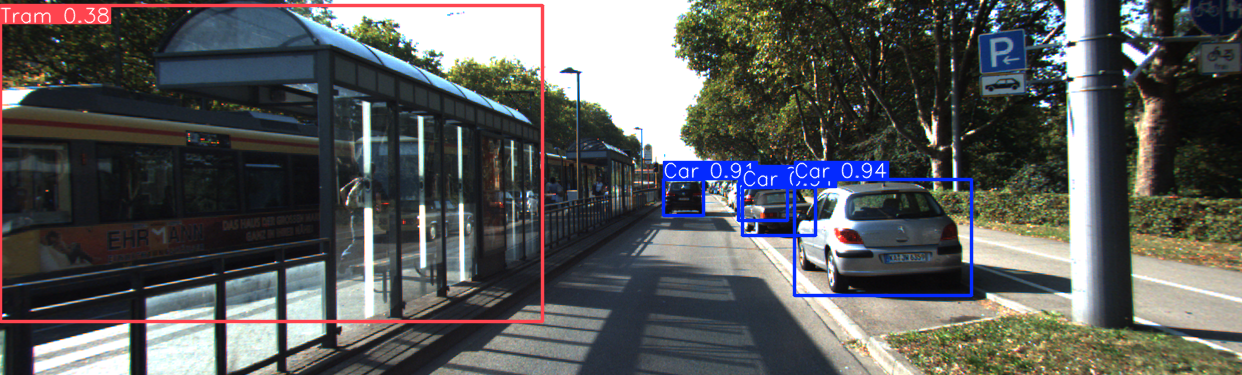

In [ ]:
from ultralytics import YOLO

# Try loading and running inference with the trained model
model = YOLO("runs/detect/yolov8n_eiou_base_hypers_pat20/weights/best.pt")  # path to your trained model
results = model.predict("/workspace/000007.png")  # use any sample image
results[0].show()


In [4]:
import shutil

# Specify the folder path and the destination zip file path
folder_path = 'runs/detect/yolov8n_eiou_base_hypers_pat20'
zip_file_path = 'runs/detect/yolov8n_eiou_base_hypers_pat20.zip'

# Create a zip file from the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

'/workspace/ultralytics/runs/detect/yolov8n_eiou_base_hypers_pat20.zip'

In [5]:
import shutil

# Specify the folder path and the destination zip file path
folder_path = '/workspace/yolov8n_eiou_base_hypers_pat20_val'
zip_file_path = '/workspace/yolov8n_eiou_base_hypers_pat20_val.zip'

# Create a zip file from the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

'/workspace/yolov8n_eiou_base_hypers_pat20_val.zip'